In [1]:
# clean up outputs from warnings
import warnings
warnings.filterwarnings("ignore")

# required imports 
import numpy as np
import pandas as pd
import networkx as nx
import scraper
import matplotlib.pyplot as plt
import powerlaw
import scipy.stats as sps
from itertools import chain

We begin by fetching the first 3 levels of the `Wikipedia vital articles` category using our own `scraper`. The resulting initial graph is also saved for later use. We used the `page_class` node attribute to separate the classes of `user` and `article`. Nodes $a$ and $b$ from the `article` class were connected by edge $a \rightarrow b$ if the content of the Wikipedia article corresponding to $a$ contained a link to article $b$. Similarly, directed edges $u \rightarrow a$ were added between article $a$ and all user nodes $u$ found by parsing the corresponding talk page.

In [2]:
category_titles = [
    "Category:Wikipedia_level-1_vital_articles",
    "Category:Wikipedia_level-2_vital_articles",
    "Category:Wikipedia_level-3_vital_articles",
]
page_graph, infos  = await scraper.scrape_wiki(category_titles)
nx.write_graphml(page_graph, "wikigraph.graphml")

Next we remove bot users. Our list of bot user names was compiled by filtering nodes of type `user` containing the substring `bot`. Since Wikipedia doesn't have an official bot name convention we verified the resulting user list manually. We then compute basic network properties on the remaining graph.

In [3]:
# read saved initial graph
graph = nx.read_graphml("wikigraph.graphml")

# remove bot users from graph
bot_names = ["User:Community Tech bot", "User:PrimeBOT", "User:InternetArchiveBot", "User:AnomieBOT", "User:RMCD bot", "User:Cyberbot II", "User:CommonsNotificationBot",
"User:LinkBot", "User:FairuseBot", "User:BetacommandBot", "User:Legobot", "User:DumZiBoT"]
graph.remove_nodes_from(bot_names)

# Print network properties
print(f"Number of nodes: {graph.number_of_nodes()}")
print(f"Number of edges: {graph.number_of_edges()}")
print(f"Average clustering coefficient: {nx.average_clustering(graph)}")
print(f"Number of weakly connected components: {len(list(nx.weakly_connected_components(graph)))}")
degrees_dict = {"Node": dict(graph.degree).keys(), "Total Degree": dict(graph.degree).values(), "In Degree": dict(graph.in_degree).values(), "Out Degree": dict(graph.out_degree).values()}
degrees_view = pd.DataFrame(degrees_dict).set_index("Node")
print("Top 5 nodes with largest in-degree:")
degrees_view.sort_values(["Total Degree"], ascending=False).head(5)

Number of nodes: 80580
Number of edges: 176368
Average clustering coefficient: 0.04063680702604195
Number of weakly connected components: 1
Top 5 nodes with largest in-degree:


,Total Degree,In Degree,Out Degree
Node,,,
United States,2458,2276,182
Jesus,1942,1903,39
India,1835,1652,183
Climate change,1800,1777,23
Israel,1696,1636,60


In [55]:
graph_u = graph.to_undirected()

# filter for user names and article titles in the graph
nodes_by_class = dict(graph.nodes(data="page_class"))
user_names = [node for node in nodes_by_class if nodes_by_class[node] == "user"]
article_titles = [node for node in nodes_by_class if nodes_by_class[node] == "article"]

users_graph = graph.subgraph(user_names)
articles_graph = graph.subgraph(article_titles)
print(f"Number of article pages: {articles_graph.number_of_nodes()}")
print(f"Connections between article pages: {articles_graph.number_of_edges()}")
print(f"Connections between user pages: {users_graph.number_of_edges()}")

# returns true if the edge with endpoints u and v is between an article and a user node
def isDifferentClass(graph, u, v):
    ua = graph.nodes[u]["page_class"] == "user" and graph.nodes[v]["page_class"] == "article"
    au = graph.nodes[u]["page_class"] == "article" and graph.nodes[v]["page_class"] == "user"
    return ua or au

print(f"Connections between users and articles: {len([(u,v) for (u, v) in graph_u.edges() if isDifferentClass(graph_u, u, v)])}")

Number of article pages: 1000
Connections between article pages: 17311
Connections between user pages: 0
Connections between users and articles: 159057


Below we plot the total degree distribuiton on a log-log scale. As we can see, our network is scale-free. Since the number of edges between articles is much smaller than the number of edges between users and articles. This means that the differences in degrees are for the most part caused by the edges corresponding to user edits. Therefore we conclude that a a minority of the articles are edited by a majority of the users.

In [4]:
# Plotting degree distributions

## Analysis of the articles subgraph

First we analyse the subgraph constructed by only taking the article nodes from our initial graph and the edges between them. We investigate number of nodes, edges, average clustering coefficient and top 5 nodes by in and out degree.

In [137]:
article_references = pd.DataFrame(articles_graph.in_degree, columns=["Node", "In Degree"]).set_index("Node")
article_references["Out Degree"] = pd.Series(dict(articles_graph.out_degree).values(), index=dict(articles_graph.out_degree).keys())
article_references["Total Degree"] = pd.Series(dict(articles_graph.degree).values(), index=dict(articles_graph.degree).keys())
print("Properties of the articles subgraph:")
print(f"Number of nodes: {articles_graph.number_of_nodes()}")
print(f"Number of edges: {articles_graph.number_of_edges()}")
print(f"Average clustering coefficient: {nx.average_clustering(articles_graph)}")
print("Top 5 articles by in-degree:")
print(article_references.sort_values("In Degree", ascending=False).head(5))
print("Top 5 articles by out-degree:")
print(article_references.sort_values("Out Degree", ascending=False).head(5))

Properties of the articles subgraph:
Number of nodes: 1000
Number of edges: 17311
Average clustering coefficient: 0.14285079028156009
Top 5 articles by in-degree:
                   In Degree  Out Degree  Total Degree
Node                                                  
Human history            130           5           135
Human                    103          15           118
Europe                   101         128           229
History of Europe         87           4            91
Asia                      85          71           156
Top 5 articles by out-degree:
               In Degree  Out Degree  Total Degree
Node                                              
World War II          27         210           237
Latin                 19         209           228
India                 51         183           234
United States         55         182           237
Aristotle             35         171           206


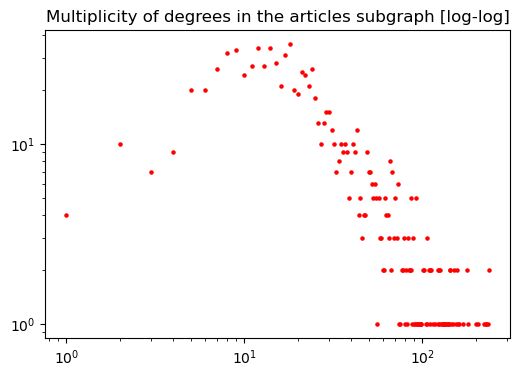

In [140]:
fig, ax = plt.subplots(figsize=(6, 4))
degree_counts = article_references["Total Degree"].value_counts()
ax.scatter(degree_counts.index, degree_counts.values, s=5, label='Data', color="red")
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title('Multiplicity of degrees in the articles subgraph [log-log]')
plt.show()

As we can see the articles subgraph is not scale-free. Next we perform community detection using the `louvain_community_detection` function which implements the [Louvain algorithm](https://sites.google.com/site/findcommunities/).

In [107]:
def louvain_community_detection(graph):
    graph_no_isolated = graph.copy()
    graph_no_isolated.remove_nodes_from([node for node in graph.nodes if graph.degree(node) < 1])
    louvain_partition_raw = nx.community.louvain_communities(graph_no_isolated)
    print("Number of communities found: ", len(louvain_partition_raw))
    print("Modularity of louvain partitions: ", nx.community.modularity(graph_no_isolated, louvain_partition_raw))
    return louvain_partition_raw

In [153]:
louvain_partition = louvain_community_detection(articles_graph)

Number of communities found:  21
Modularity of louvain partitions:  0.2943964685825948


In [154]:
def plot_community_sizes(partition, ax, title):
    sorted_size_communities = sorted([len(comm) for comm in partition])
    ax.bar([x for x in range(1,len(partition)+1)], sorted_size_communities, color="cornflowerblue")
    ax.set_title(label=title)
    ax.set_xlabel(xlabel="Index of communities")
    ax.set_ylabel(ylabel="Number of nodes")
    ax.set_xticks([x for x in range (1,len(partition)+1)])
    max_c = sorted_size_communities[-1]
    ax.set_ylim((0, max_c + 40))

    rects = ax.patches
    labels = [size for size in sorted_size_communities]

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom")

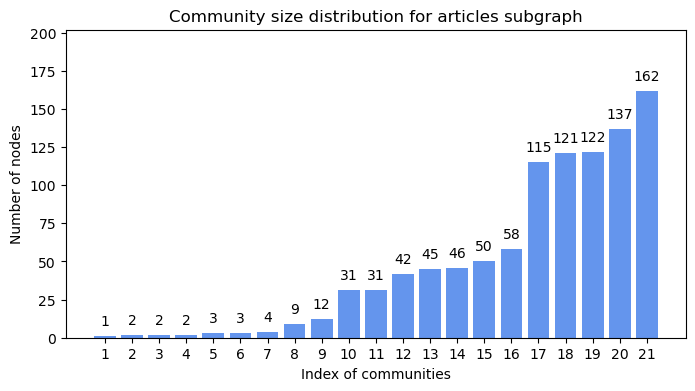

In [155]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_community_sizes(louvain_partition, ax, "Community size distribution for articles subgraph")  
plt.show()

Throughout multiple runs, the algorithm detected from 15 to 20 communities with a modularity under 0.3 each time. The above figure shows the size distribution of the communities found during our last run of the algorithm. The low modularity and the excessively small or large communities could be a result of the wikipedia article subset, as the vital articles category aims to provide an overview with a diverse set of important topics.

## Shared user groups between article pairs

We create a graph where the nodes are the articles and two nodes are connected by an edge of weight $w$ if exactly $w$ users contributed to both. Groups of shared articles are constructed using function `add_weighted_edges` by evaluating each article nodes' neighbourhoud in the source graph. The weighted edges corresponding to the shared editor groups is then added.

In [6]:
def add_weighted_edges(graph, source, node_type, frontier_type, frontier_key):
    for node in list(graph.nodes):
        related = {}
        # get neighbouring nodes of the opposite type
        frontier = set(n for n in source.neighbors(node) if source.nodes[n]["page_class"] == frontier_type)
        graph.nodes[node][frontier_key] = len(frontier)
        for f in frontier:
            neighbor_nodes = list( n for n in source.neighbors(f) if source.nodes[n]["page_class"] == node_type)
            for n in neighbor_nodes:
                if n != node:
                    if n in related:
                        related[n] += 1
                    else:
                        related[n] = 1
        graph.add_weighted_edges_from([(node, r, related[r]) for r in related])

In [7]:
common_editors = nx.Graph()
common_editors.add_nodes_from(article_titles)
add_weighted_edges(common_editors, graph_u, "article", "user", "editors_no")

We then perform analysis on the  resulting undirected weighted graph. As we can see, there has been a slight reordering in the top 5 articles by editor number. This is probably due to users that only contributed to one article being filtered out during construction of the graph

In [8]:
print(f"Number of nodes: {common_editors.number_of_nodes()}")
print(f"Number of edges: {common_editors.number_of_edges()}")
print(f"Number of connected components: {nx.number_connected_components(common_editors)}")
print(f"Average clustering coefficient: {nx.average_clustering(common_editors)}")
edge_weight_dict = nx.get_edge_attributes(common_editors, "weight")
editors_dict = common_editors.nodes(data="editors_no")
editors_view = pd.DataFrame(editors_dict, columns=["Node", "Editors"]).set_index("Node")
print(f"Maximum editors: {editors_view.Editors.max()}")
print(f"Average editors: {editors_view.Editors.mean()}")
print(f"Median editors: {editors_view.Editors.median()}")

print("\nTop 5 nodes by overall number of editors:")
editors_view.sort_values(["Editors"], ascending=False).head(5)


Number of nodes: 1000
Number of edges: 242107
Number of connected components: 3
Average clustering coefficient: 0.708347877885475
Maximum editors: 2221
Average editors: 159.057
Median editors: 86.0

Top 5 nodes by overall number of editors:


,Editors
Node,
United States,2221
Jesus,1879
Climate change,1768
Israel,1612
India,1601


In [18]:
degree_a = [editors_dict[edge[0]] for edge in edge_weight_dict.keys()]
degree_b = [editors_dict[edge[1]] for edge in edge_weight_dict.keys()]
edges = [f"{u}, {v}" for (u, v) in edge_weight_dict.keys()]
shared_user_df = pd.DataFrame({"Edge": edges, "Weight": edge_weight_dict.values(), "Editors A": degree_a,
                              "Editors B": degree_b}).set_index("Edge")
print(f"Maximum edge weight: {shared_user_df.Weight.max()}")
print(f"Average edge weight: {shared_user_df.Weight.mean()}")
print(f"Median edge weight: {shared_user_df.Weight.median()}")
print("\nTop 10 node pairs by overall number of shared editors:")
most_raw_connected = shared_user_df.sort_values(["Weight"], ascending=False).head(10)
most_raw_connected

Maximum edge weight: 221
Average edge weight: 3.3285695993920044
Median edge weight: 2.0

Top 10 node pairs by overall number of shared editors:


,Weight,Editors A,Editors B
Edge,,,
"Christianity, Jesus",221,985,1879
"Israel, Jerusalem",206,1612,637
"Islam, Muhammad",203,1127,1396
"Jesus, United States",178,1879,2221
"Jesus, Muhammad",176,1879,1396
"China, Taiwan",174,842,937
"Adolf Hitler, Jesus",168,1535,1879
"United Kingdom, United States",163,1188,2221
"Israel, United States",147,1612,2221


Above we see metrics of the weights assigned to edges as the top 10 article pairs by shared editor count. Now we normalize the weights by the number of editors for each individual article. While there are a few surprising connections (e.g. Adolf Hitler and Jesus), most of the node pairs we see here are semantically related. We also note that these topics also have a high editor count individually which contributes to them being part of the top 10.

Now we will investigate what percentage of their editors different articles share with others. We will construct a directed graph this time, and compute a relative for edge $a \rightarrow b$ in the following way:
$$w_{rel} = \frac{w}{editors(a)} \cdot 100$$
where $w$ is the number of shared editors between $a$ and $b$ and $editors(a)$ is the corresponding number of editors for article $a$. We can compute the relative weights for all edges directly using `shared_user_df`. The 100 multiplier was added to give a percentage view of the results.

In [30]:
shared_user_df["Relative Weight (%)"] = shared_user_df.Weight / shared_user_df["Editors A"] * 100
desc_rel_weight = shared_user_df.sort_values(["Relative Weight (%)"], ascending=False)
print(f"Max edge weight: {shared_user_df['Relative Weight (%)'].max()}")
print(f"Average edge weight: {shared_user_df['Relative Weight (%)'].mean()}")
print(f"Median edge weight: {shared_user_df['Relative Weight (%)'].median()}")
print("\nTop 10 node pairs by ratio of shared editors:")
desc_rel_weight[(desc_rel_weight["Editors A"] > 20) & (desc_rel_weight["Editors B"] > 20)].head(10)

Max edge weight: 100.0
Average edge weight: 2.2928565414885926
Median edge weight: 1.5965939329430547

Top 10 node pairs by ratio of shared editors:


,Weight,Editors A,Editors B,Relative Weight (%)
Edge,,,,
"History of India, India",83,205,1601,40.487805
"Delhi, India",72,181,1601,39.779006
"Post-classical history, United States",11,28,2221,39.285714
"Nth root, Pi",12,31,587,38.709677
"Visual arts, Art",12,32,165,37.500000
"Post-classical history, Middle Ages",10,28,206,35.714286
"Deity, God",18,51,642,35.294118
"Climate, Climate change",14,40,1768,35.000000
"Bhagavad Gita, Hinduism",44,126,554,34.920635


As we can see, the article pairs ranked higher by relative weight have a stronger semantic connection. The maximal relative weight for an edge is 1.0. This is because some articles have only one editor in our subset and as soon as they edit another article, the edge with weight 1.0 is created. To avoid overrepresenting these types of connections we chose to only evaluate connections of the articles with at least 20 editors. 

As we can see above, the relative weight metric uncovers strong connections between more niche topics as well (e.g between Mahayana and Theravada buddhism). Now let's see the shared user percentages for the highest ranking edges by overall number of editors.

In [27]:
top_by_count = shared_user_df.loc[most_raw_connected.index]
no_higher = len(shared_user_df.loc[shared_user_df['Relative Weight (%)'] > top_by_count['Relative Weight (%)'].max()])
all_above_min = len(shared_user_df.loc[shared_user_df['Relative Weight (%)'] >= top_by_count['Relative Weight (%)'].min()])
print(f"Number of edges with higher weights: {no_higher}")
print(f"Below edges are in the top {all_above_min / len(shared_user_df) * 100:.2}%")
print("\nRelative shared editors for the top 10 edges by shared editor number:")
top_by_count

Number of edges with higher weights: 312
Below edges are in the top 2.1%

Relative shared editors for the top 10 edges by shared editor number:


,Weight,Editors A,Editors B,Relative Weight (%)
Edge,,,,
"Christianity, Jesus",221,985,1879,22.436548
"Israel, Jerusalem",206,1612,637,12.779156
"Islam, Muhammad",203,1127,1396,18.012422
"Jesus, United States",178,1879,2221,9.473124
"Jesus, Muhammad",176,1879,1396,9.366684
"China, Taiwan",174,842,937,20.665083
"Adolf Hitler, Jesus",168,1535,1879,10.944625
"United Kingdom, United States",163,1188,2221,13.720539
"Israel, United States",147,1612,2221,9.119107


This shows that the most edited articles are still ranked very high overall. Now let's see the 5 lowest rankied topics.

In [43]:
print("Bottom 10 node pairs by percentage of shared editors:")
asc_rel_weight = shared_user_df.sort_values(["Relative Weight (%)"], ascending=True)
asc_rel_weight.head(10)

Bottom 10 node pairs by percentage of shared editors:


,Weight,Editors A,Editors B,Relative Weight (%)
Edge,,,,
"United States, Weapon",1,2221,26,0.045025
"United States, Wave",1,2221,46,0.045025
"Jesus, Word",1,1879,24,0.053220
"Jesus, Suffrage",1,1879,21,0.053220
"Jesus, Navigation",1,1879,20,0.053220
"Jesus, Lipid",1,1879,31,0.053220
"Jesus, Motion",1,1879,28,0.053220
"Jesus, Rocky Mountains",1,1879,43,0.053220
"Jesus, Realism (arts)",1,1879,9,0.053220


In [51]:
print("United States article contains link to Weapon: ", "United States" in list(articles_graph.neighbors("Weapon")))
print("Weapon article contains link to United States: ", "Weapon" in list(articles_graph.neighbors("United States")))

United States article contains link to Weapon:  True
Weapon article contains link to United States:  True


The low weight of the edge between the United States and Weapon articles is surprising especially because both of these articles link to each other in their page content. 

Most of the other results make sense as the article titles are not semantically related to each other. ,  Most of the above results make sense as the article pairs do not have much in common sematically.

Overall by focusing on user collaboration, we see a different article network structure emerging to the one constructed through page content links. Let us investigate this through community detection using the [Louvain algorithm](https://sites.google.com/site/findcommunities/).

In [110]:
common_editors_rel = nx.Graph()
common_editors_rel.add_nodes_from(article_titles)

s = shared_user_df["Relative Weight (%)"]
edge_endpoints = np.array([edge_str.split(", ") for edge_str in s.index])
rel_weighted_edges = list(zip(edge_endpoints[:,0], edge_endpoints[:,1], s))
common_editors_rel.add_weighted_edges_from(rel_weighted_edges)

print(f"Number of nodes: {common_editors_rel.number_of_nodes()}")
print(f"Number of edges: {common_editors_rel.number_of_edges()}")
print(f"Average clustering coefficient: {nx.average_clustering(common_editors_rel)}")

Number of nodes: 1000
Number of edges: 242107
Average clustering coefficient: 0.708347877885475


In [191]:
print("Weights are raw shared editor numbers:")
louvain_partition_raw = louvain_community_detection(common_editors)

print("---------------------------------")

print("Weights are relative shared editor numbers:")
louvain_partition_rel = louvain_community_detection(common_editors_rel)

Weights are raw shared editor numbers:
Number of communities found:  6
Modularity of louvain partitions:  0.14304896102858722
---------------------------------
Weights are relative shared editor numbers:
Number of communities found:  5
Modularity of louvain partitions:  0.14547546653848578


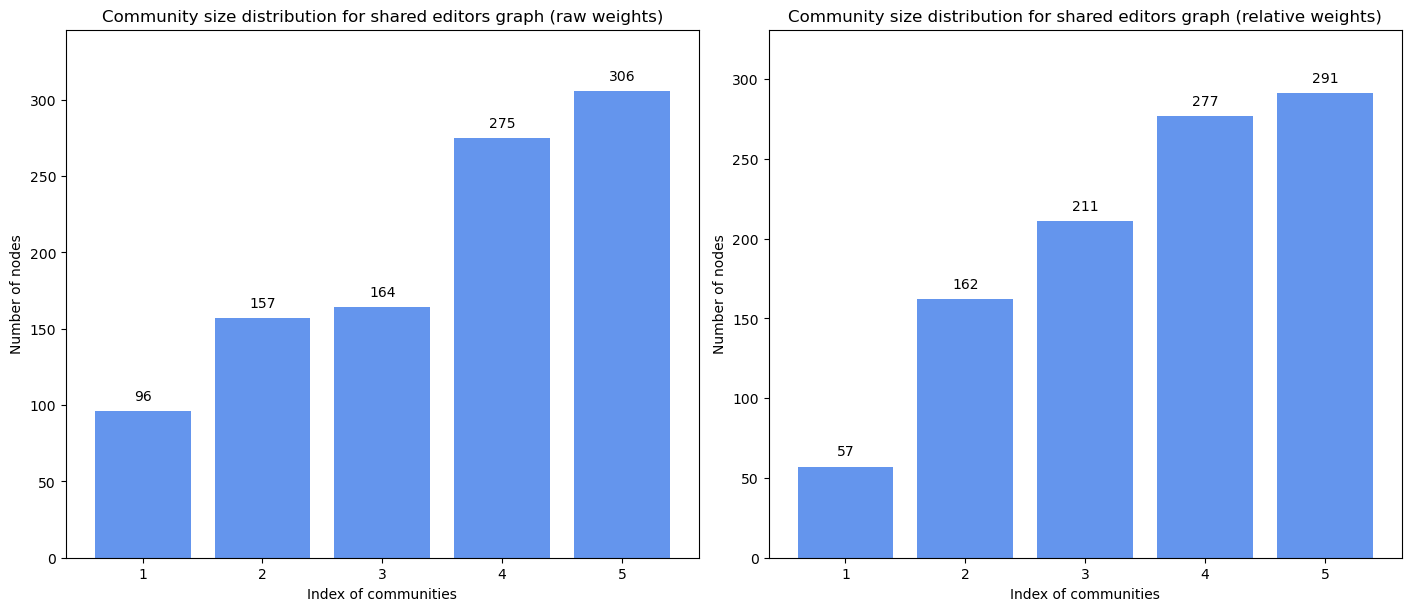

In [189]:
titles = ["Community size distribution for shared editors graph (raw weights)", "Community size distribution for shared editors graph (relative weights)"]
partitions = [louvain_partition_raw, louvain_partition_rel]
fig, ax = plt.subplots(1, 2, figsize=(14, 6), layout="constrained")
for idx, (title, partition) in enumerate(zip(titles, partitions)):
    plot_community_sizes(partition, ax[idx], title)
plt.show()


These results suggest that user preferences usually do not align to the groupings based on article topics. While we see users with specific expertise mainly contributing to a small niche of articles; the more popular ond/or controversial topics have a major appeal to all users. 
This difference in connectedness is also reflected by the difference in the average clustering coefficient of the graphs. Two arbirarily chosen nodes are much more likely to have an edge between them in the shared editors graph than the article subgraph.

The Louvain algorithm identified fewer communities in the shared editors graph than for the articles subgraph. This further emphasises the differences in strucure between the two, even though neither partition had a high modularity. 

These differences may contribute to diverse discussions on article talk pages, particularly for popular topics where there are likely more conflicts.